# Apply the trained model to new data

We will apply the trained model to an approximately 1 km x 1 km region centered at a point in Charlotte County, VA. This region is close to (but does not overlap with) the regions used to train the model; since the land type is very similar, we expect reasonable performance despite the short training time and limited training dataset.

We will assume that you've already completed the [training](Train_a_land_classification_model_from_scratch.ipynb) notebook in this folder, which will have installed dependencies, produced a trained model, and copied evaluation data to your VM.

## Load dependencies

In [1]:
import numpy as np
import pandas as pd
import os, argparse, cntk, tifffile, warnings, osr
from osgeo import gdal
from gdalconst import *
from mpl_toolkits.basemap import Basemap
from collections import namedtuple
from PIL import Image

## Load the model and evaluation data

We load the NAIP and Landcover files using the same transposition and normalization strategy seen during training. We also lump together the barren and impervious land cover labels.

In [2]:
# The default filename points to your model trained for one epoch.
# You can also try using our sample model, 250epochs.model
model_filename = 'D:/pixellevellandclassification/models/trained.model'

naip_filename = 'D:/pixellevellandclassification/evaluation_data/C14_NAIP.tif'
lc_filename = naip_filename.replace('_NAIP.tif', '_LandCover.tif')

model = cntk.load_model(model_filename)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    naip_image = np.transpose(tifffile.imread(naip_filename))  / 255.0
    true_lc_image = np.transpose(tifffile.imread(lc_filename))
true_lc_image[true_lc_image > 4] = 4

## Find the relevant subregion of the image

Our evaluation images cover a large area, but for illustration purposes, we will perform predictions on a 1024 meter x 1024 meter region centered at (37.055522, -78.638640). A helper function will find the indices of the pixel at the center of this region using the geospatial header information in the NAIP file. Notice that we extract a slightly larger region from the NAIP image to accommodate the difference between the model's input and output region sizes, as we'll describe in more detail below.

In [3]:
def find_pixel_from_latlon(img_filename, lat, lon):
    ''' Find the indices for a point of interest '''
    img = gdal.Open(img_filename, GA_ReadOnly)
    img_proj = osr.SpatialReference()
    img_proj.ImportFromWkt(img.GetProjection())
    ulcrnrx, xstep, _, ulcrnry, _, ystep = img.GetGeoTransform()

    world_map = Basemap(lat_0=0,
                        lon_0=0,
                        llcrnrlat=-90, urcrnrlat=90,
                        llcrnrlon=-180, urcrnrlon=180,
                        resolution='c', projection='stere')
    world_proj = osr.SpatialReference()
    world_proj.ImportFromProj4(world_map.proj4string)
    ct_to_img = osr.CoordinateTransformation(world_proj, img_proj)

    xpos, ypos = world_map(lon, lat, inverse=False)
    xpos, ypos, _ = ct_to_img.TransformPoint(xpos, ypos)
    x = int((xpos - ulcrnrx) / xstep)
    y = int((ypos - ulcrnry) / ystep)

    return(x,y)

region_dim = 512
delta = int(region_dim / 2)
padding = 64

center_x, center_y = find_pixel_from_latlon(naip_filename, 37.055522, -78.638640)
true_lc_image = true_lc_image[center_x - delta:center_x + delta,
                              center_y - delta:center_y + delta].astype(np.float32)
naip_image = naip_image[:,
                        center_x - (delta + padding):center_x + delta + padding,
                        center_y - (delta + padding):center_y + delta + padding].astype(
                            np.float32)

## Applying the model across the region of interest


Our trained model takes an input with dimensions 256 pixels x 256 pixels, and produces an output with dimensions 128 x 128 (corresponding to the center of the input region). To get output labels for the entire region of interest, the evaluation script must therefore use a tiling strategy, which is illustrated in the figure below.

<img src="https://github.com/Azure/pixel_level_land_classification/raw/master/outputs/tiling_strategy.PNG">

The model is first applied to the region at top-left of the extracted NAIP data. Since the aerial image data is appropriately padded, the model's output corresponds to the top-left corner of the actual region of interest. Next, we slide the model's input window 128 pixels to the right; the model's output for this tile corresponds to an adjacent location in the region of interest. Once we have covered all columns in a row, we shift the input window 128 pixels down and back to the left-hand boundary of the aerial image data. Finally, the model's predictions for all tiles are stitched together to produce a single result.

In [4]:
n_rows = int(region_dim / 128)

# The model's predictions will have five values for each x-y position:
# these can be used to find the relative predicted probabilities of
# each of the five labels.
pred_lc_image = np.zeros((5, true_lc_image.shape[0], true_lc_image.shape[1]))

for row_idx in range(n_rows):
    for col_idx in range(n_rows):
        # Extract a 256 x 256 region from the NAIP image, to feed into the model.
        sq_naip = naip_image[:,
                             row_idx * 128:(row_idx * 128) + 256,
                             col_idx * 128:(col_idx * 128) + 256]
        
        # Get the model's prediction for the center of that region
        sq_pred_lc = np.squeeze(model.eval({model.arguments[0]: [sq_naip]}))
        
        # Save the predictions in the appropriate region of the result matrix
        pred_lc_image[:,
                      row_idx * 128:(row_idx * 128) + 128,
                      col_idx * 128:(col_idx * 128) + 128] = sq_pred_lc

C:\Anaconda\envs\py35\lib\site-packages\cntk\core.py:82: RuntimeWarning: data is not C contiguous; rearrange your data/computation to avoid costly data conversions
  RuntimeWarning)


## Visualize the region of interest (aerial imagery)

To visualize the image, we transform it back to its original shape and value range (0-255). We also drop the near-infrared channel, retaining only the RGB channels for accurate visualization. (Many renderers, including the Python Image Library aka `pillow`, would incorrectly interpret the fourth channel as an "alpha" or transparency indicator.)

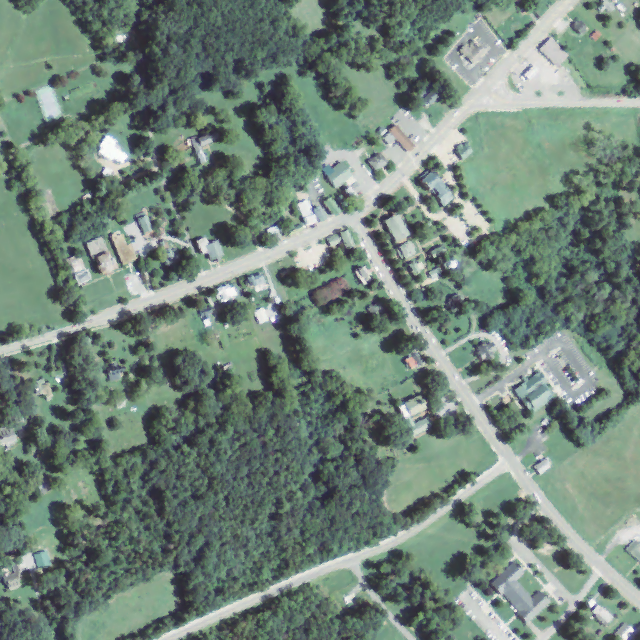

In [5]:
img_naip = Image.fromarray(np.transpose(naip_image * 255)[:, :, :3].astype(np.uint8))
img_naip

## Visualize the true and predicted land cover labels

Our trained model outputs predictions for five classes, which we will visualize using the following color code:
- No data: black
- Water: blue
- Trees: dark green
- Herbaceous: light green
- Barren/impervious: gray

Notice that the function `visualize_label_image()` can colorize predictions using either "hard" or "soft" labels. With "hard" labeling, each pixel is assigned the color of the most likely label. With "soft" labeling, each pixel's color is a blend of all five label colors, weighted according to each label's predicted probability.

Ground-truth labels can also be colorized: since there is no uncertainty information in the true labels, "hard" labels are the most appropriate.

In [12]:
color_map = np.asarray([[0,0,0],
                        [0,0,1],
                        [0,0.5,0],
                        [0.5,1,0.5],
                        [0.5,0.375,0.375]], dtype=np.float32)

def visualize_label_image(input_image, hard=True):
    num_labels, height, width = input_image.shape
    label_image = np.zeros((3, height, width))
    if hard:
        my_label_indices = input_image.argmax(axis=0)
        for label_idx in range(num_labels):
            for rgb_idx in range(3):
                label_image[rgb_idx, :, :] += (my_label_indices == label_idx) *\
                    color_map[label_idx, rgb_idx]
    else:
        input_image = np.exp(input_image) / np.sum(np.exp(input_image), axis=0)
        for label_idx in range(num_labels):
            for rgb_idx in range(3):
                label_image[rgb_idx, :, :] += input_image[label_idx, :, :] * \
                    color_map[label_idx, rgb_idx]
    label_image = np.transpose(label_image * 255).astype(np.uint8)
    return(label_image)

### Predicted land cover labels

Your results may vary from the sample included in this notebook. After only one epoch of training, your model's results will be sub-optimal, but you should expect to see outlines of roads and buildings that correspond to the NAIP image shown above. If you like, change the argument to `hard=False` and run the cell again to see the difference.

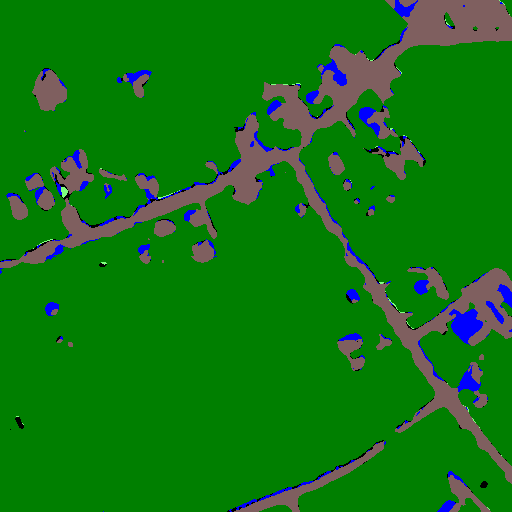

In [16]:
img_labels_pred = Image.fromarray(visualize_label_image(pred_lc_image, hard=True))
img_labels_pred

### Ground-truth land cover labels

For comparison, the true labels are visualized below. Note that in order to reuse our `visualize_label_image()` function, we need to reshape the true labels as though they were predictions made by our model.

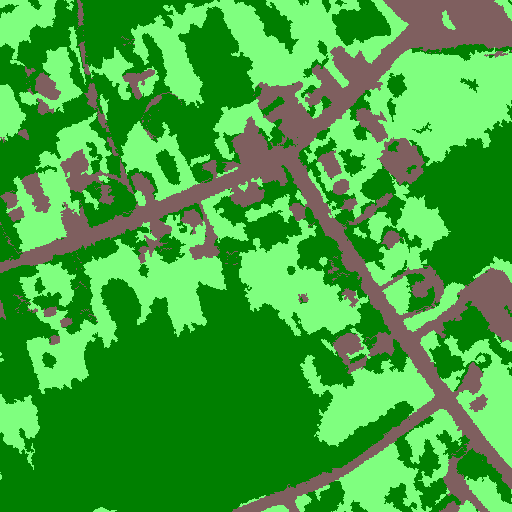

In [18]:
temp = np.transpose(np.eye(5)[true_lc_image.astype(np.int32)], [2, 0, 1])
img_labels_true = Image.fromarray(visualize_label_image(temp, hard=True))
img_labels_true

## Next steps

In this tutorial, you learned how to apply the trained model to new images. In our next notebook on model integration with [ArcGIS Pro](./Apply_trained_model_in_ArcGIS_Pro.ipynb), you will see how to apply real-time predictions during interactive exploration in a GUI.